## Evolution of a system of coupled scalar waves in 1D

$$\dfrac{d\phi}{dt} = \mu$$

$$\dfrac{d\mu}{dt} = c^{2}_{\phi} \dfrac{d^2\phi}{dx^2}$$

$$\dfrac{d\zeta}{dt} = \nu - \gamma(t) (\zeta - \phi)$$

$$\dfrac{d\nu}{dt} = c^{2}_{\zeta} \dfrac{d^2\zeta}{dx^2}$$

where, $\gamma$ is the coupling factor/stiffness parameter

With initial conditions:

$$ \phi(x,t) = \phi(x,0) = \exp \left(-\dfrac{(x-1)}{\sigma}\right)^2 $$

$$ \dfrac{d \phi}{dt} (x,0) = \mu(x,0) = 0 $$

$$ \zeta(x,t) = \zeta(x,0) = \exp \left(-\dfrac{(x-1)}{\sigma}\right)^2 $$

$$ \dfrac{d \zeta}{dt} (x,0) = \nu(x,0) = 0 $$

and boundary conditions:

$$ \phi(x,t) = \phi(x + L,t), 0 \leq x \leq 2 $$
$$ \zeta(x,t) = \zeta(x + L,t), 0 \leq x \leq 2 $$

### Jacobian & stiffness detection

Set of PDE can be written as:

$$
\partial_t  
\left[\begin{array}{cc} 
\phi \\
\mu \\
\zeta \\
\nu
\end{array}\right]
=  
\left[\begin{array}{cc} 
0 & 1 & 0 & 0 \\
c^2 _\phi \nabla^2 & 0 & 0 & 0 \\
\gamma & 0 & -\gamma & 1 \\
0 & 0 & c^2 _\zeta \nabla^2 & 0
\end{array}\right]

\left[\begin{array}{cc} 
\phi \\
\mu \\
\zeta \\
\nu
\end{array}\right]
$$

Then the Jacobian matrix with $f_i = ( \partial_t \phi, \partial_t \mu, \partial_t \zeta, \partial_t \nu )$ and $q_i = ( \phi, \mu ,\zeta, \nu )$ is:

$$
J_{ik} = \dfrac{\partial f_i}{\partial q_k} = \left[\begin{array}{cc} 
0 & 1 & 0 & 0 \\
c^2 _\phi & 0 & 0 & 0 \\
\gamma & 0 & -\gamma & 1 \\
0 & 0 & c^2 _\zeta  & 0
\end{array}\right]
$$

Then $\lambda$ is the dominant/leading eigenvalue of the Jacobian.

Let $LSB$ denote the linear stability boundary: the intersection of the linear stability region with the negative real axis. The product $(h \lambda)$ gives an estimate that can be compared to the linear stability boundary of a method in order to detect stiffness:

$$ |h \lambda| \leq s |LSB|$$


where $s$ is a safety factor.

References:

1. https://reference.wolfram.com/language/tutorial/NDSolveStiffnessTest.html 
2. https://pages.mtu.edu/~struther/Courses/OLD/Other/LessOld/5628_11/ExpRK_Pairs_StiffDetect_MathCompModle_2004_Sofroniou_Spaletta.pdf 
3. http://www.scholarpedia.org/article/Equilibrium
4. https://webspace.science.uu.nl/~frank011/Classes/numwisk/ch10.pdf
5. https://en.wikiversity.org/wiki/Numerical_Analysis/stability_of_RK_methods
6. https://homepage.math.uiowa.edu/~whan/3800.d/S8-4.pdf







In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def compute_dt(cf,dx,c):
    dt = (cf*dx)/c
    return dt

##----------------------------Second order finite difference method--------------------------------##
def second_derivative_CFD2(var,dx):
    D2_var = np.zeros(len(var))
    var_with_ghosts = exterior_points_CFD2(var)
    for i in range (1,len(var_with_ghosts)-1): # calculates only interior
        # Central finite difference method:
        D2_var[i-1] = (var_with_ghosts[i-1] - 2*var_with_ghosts[i] + var_with_ghosts[i+1])/dx**2
    return D2_var

def exterior_points_CFD2(var):
    var_left_ghost = np.append(var[len(var)-1],var)
    var_ghosts = np.append(var_left_ghost,var[0])
    return var_ghosts

##----------------------------Fourth order finite difference method--------------------------------##
#Ref: https://www.mech.kth.se/~ardeshir/courses/literature/fd.pdf
def second_derivative_CFD4(var,dx):
    D2_var = np.zeros(Nx)
    var_with_ghosts = exterior_points_CFD4(var)
    for i in range (2,len(var_with_ghosts)-2):
        # Central finite difference method:
        D2_var[i-2] = (-var_with_ghosts[i+2] + 16*var_with_ghosts[i+1] - 30*var_with_ghosts[i]
                       + 16*var_with_ghosts[i-1] - var_with_ghosts[i-2]  )/(12*dx**2)
    return D2_var

def exterior_points_CFD4(var):
    var_l1_ghost = np.append(var[len(var)-1],var)
    var_l2_ghost = np.append(var[len(var)-2],var_l1_ghost)
    var_r1_ghost = np.append(var_l2_ghost,var[0])
    var_r2_ghost = np.append(var_r1_ghost,var[1])
    var_ghosts = var_r2_ghost
    return var_ghosts

In [3]:
##------------Explicit Time integrators------------------------------##

def RK2(rhs,u_n,dt):
    k1 = np.array(rhs(u_n))
    k2 = np.array(rhs(u_n + (dt/2)*k1))
    u_np1 = u_n + dt*k2
    return u_np1

def RK4(rhs,u_n,dt):
    k1 = np.array(rhs(u_n))
    k2 = np.array(rhs(u_n + (dt/2)*k1))
    k3 = np.array(rhs(u_n + (dt/2)*k2))
    k4 = np.array(rhs(u_n + dt*k3))
    u_np1 = u_n + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)
    return u_np1


##--------------------IMEX(1,2,2) Method-----------------------------##

def IMEX_midpoint_122(f,G,u0,dt):
    k1_hat = np.array(f(u0))
    alpha = dt/2
    beta = u0 + alpha*k1_hat
    u1 = np.array(G(alpha,beta))
    k2_hat = np.array(f(u1))
    k1 = np.array( (u1-beta)/alpha )
    u_np1 = u0 + dt*k2_hat + dt*k1
    return u_np1

##--------------------IMEX(3,4,3) Method------------------------------##

# Define Butcher table elements
#------------------------------------------------------------#

Gamma = 0.4358665215
delta = -0.644373171
eta = 0.3966543747
mu = 0.5529291479

def implicit_butcher_table_a(i,j):
    a_imp = np.array([[0,0,0,0],
                  [0,Gamma,0,0],
                  [0,(1 - Gamma)/2,Gamma,0],
                  [0,(1-Gamma-delta),delta,Gamma]])
    return a_imp[i,j]
def explicit_butcher_table_a_hat(i,j):
    i,j = (i-1),(j-1)
    a_exp = np.array([[0,0,0,0],
                  [Gamma,0,0,0],
                  [((1 + Gamma)/2) - eta,eta,0,0],
                  [(1-2*mu),mu,mu,0]])
    return a_exp[i,j]

def implicit_b(i):
    b = np.array([0,(1-Gamma-delta),delta,Gamma])
    return b[i]

def explicit_b(i):
    i = i - 1
    b = np.array([0,(1-Gamma-delta),delta,Gamma])
    return b[i]

#------------------------------------------------------------#


def IMEX_343(f,G,a,a_hat,b,b_hat,u0,h):
    # alpha = dt*a_imp(1,1) = dt*a_imp(2,2) = dt*a_imp(3,3) = dt*Gamma
    alpha = h*Gamma
    #--------------Stage 1----------------#
    k1_hat = np.array(f(u0))
    beta_1 = u0 + h*a_hat(2,1)*k1_hat
    u1 = np.array(G(alpha,beta_1)) 
    #--------------Stage 2----------------#
    k1 = np.array( (u1-beta_1)/alpha ) #g(u_1)
    k2_hat = np.array(f(u1))
    beta_2 = u0 + h*( a(2,1)*k1 + a_hat(3,1)*k1_hat + a_hat(3,2)*k2_hat )
    u2 = np.array(G(alpha,beta_2))
    #--------------Stage 3----------------#
    k2 = np.array( (u2-beta_2)/alpha ) #g(u_2)
    k3_hat = np.array(f(u2))
    beta_3 = u0 + h*( a(3,1)*k1 + a(3,2)*k2 + a_hat(4,1)*k1_hat 
                     + a_hat(4,2)*k2_hat + a_hat(4,3)*k3_hat )
    u3 = np.array(G(alpha,beta_3))
    #-------------------------------------#
    k3 = np.array( (u3-beta_3)/alpha ) #g(u_3)
    k4_hat = np.array(f(u3))
    u_np1 = u0 + h*( b(1)*k1 + b(2)*k2 + b(3)*k3 +
                   b_hat(1)*k1_hat + b_hat(2)*k2_hat + b_hat(3)*k3_hat + b_hat(4)*k4_hat )
    return u_np1

##------------------------------------------------------------------------##

In [4]:
def numerical_method_flags(time_integration_method,finite_difference_method):
    global FD_method,TI_method, RHS_func
    if (finite_difference_method == "CFD2"):
        FD_method = second_derivative_CFD2
    if (finite_difference_method == "CFD4"):
        FD_method = second_derivative_CFD4
    if (time_integration_method == "RK2"):
        TI_method = RK2
        RHS_func = lambda u_n,FD_method,dx: (scalar_wave_RHS_f(u_n,FD_method,dx) + scalar_wave_RHS_g(u_n,FD_method,dx))
    if (time_integration_method == "RK4"):
        TI_method = RK4
        RHS_func = lambda u_n,FD_method,dx: (scalar_wave_RHS_f(u_n,FD_method,dx) + scalar_wave_RHS_g(u_n,FD_method,dx))
    if (time_integration_method == "IMEX-midpoint(1,2,2)"):
        TI_method = lambda rhs,u_n,dt: IMEX_midpoint_122(rhs,IMEX_G,u_n,dt)
        RHS_func = lambda u_n,FD_method,dx: scalar_wave_RHS_f(u_n,FD_method,dx)
    if (time_integration_method == "IMEX-ARS(3,4,3)"):
        TI_method = lambda rhs,u_n,dt: IMEX_343(rhs,IMEX_G,implicit_butcher_table_a,
                                                explicit_butcher_table_a_hat,implicit_b,explicit_b,
                                               u_n,dt)
        RHS_func = lambda u_n,FD_method,dx: scalar_wave_RHS_f(u_n,FD_method,dx)

In [5]:
# # compute stablity region
# x_axis = np.arange(-6.0,-0.1,1e-6)
# x = []
# Real = []
# z = x_axis + 0.j
# R = 1 + z + 0.5*z**2 +(1/6)*z**3 + (1/24)*z**4
# R_hat = np.abs(R)
# for i in range (len(x_axis)):
#     if (R_hat[i] <= 1.0):
#         x.append(x_axis[i])
#         Real.append(R_hat[i])
# LSB = np.round(np.abs(x[np.argmax(Real)]),6)
# print("R_hat at the intersection of the LSB with the negative real axis = ",Real[np.argmax(Real)],"\nReal_value, LSB = ",LSB)
# plt.title("Stablity function in argand plane",fontsize=12)
# plt.xlabel("Real axis",fontsize=12)
# plt.ylabel("Amplitude of R(µ)",fontsize=12)
# plt.plot(x,Real)
LSB =  2.785293

In [6]:
def jacobian(stiffness):
    # global variables wave_speed_phi, stiffness
    J_matrix = np.array([[0,1,0,0],
                        [wave_speed_phi**2,0,0,0],
                        [stiffness,0,-stiffness,1],
                        [0,0,wave_speed_zeta**2,0]])
    return J_matrix

def Evolve_dynamic_integrator(init,rhs,Nt,dt):
    global comp_time,stiffness,TIM_strings
    u_0 = init()
    u_result = np.zeros((Nt,len(u_0),Nx)) #u_result[i][j][k]; i -> time, j-> variable, k-> x position
    print("Total iteration = %d"%(Nt-1))
    start_time = time.time()
    u_result[0] = np.array((u_0))
    TIM = "RK4"
    numerical_method_flags(TIM,finite_difference_method) # intially start with RK4 method
    for i in range (1,Nt):
        #Set stiffness:
        stiffness = dynamic_stiffness[i]
        J_eig = np.linalg.eigvals(jacobian(stiffness))
        J_dom_eig = np.max(np.abs(J_eig))
        s = 1 # safety factor = 1
        h_lambda = dt*J_dom_eig
        if ( h_lambda >= s*LSB ):
            TIM = "IMEX-ARS(3,4,3)"
            numerical_method_flags(TIM,finite_difference_method) # Change integrator to IMEX
            #print("Integrator: IMEX\t","stiffness = %.2f"%(stiffness),"\t J_dom_eig = %.2f"%J_dom_eig,"h*λ = %0.2f"%h_lambda)
            TIM_strings[i] = 1 # 0: RK4, 1: IMEX
            u_np1 = np.array(TI_method(rhs,u_0,dt))
        else:
            TIM = "RK4"
            #print("Integrator: RK4\t","stiffness = %.2f"%(stiffness),"\t J_dom_eig = %.2f"%J_dom_eig,"h*λ = %0.2f"%h_lambda)
            numerical_method_flags(TIM,finite_difference_method)
            TIM_strings[i] = 0 # 0: RK4, 1: IMEX
            u_np1 = np.array(TI_method(rhs,u_0,dt))
        #store result of iteration
        u_result[i] = u_np1
        #update values
        u_0 = u_np1
    end_time = time.time()
    comp_time = end_time - start_time
    print("Computation time: %f seconds"%(comp_time))
    return u_result

In [7]:
def Evolve_single_method(init,rhs,time_integration_method,Nt,dt):
    global comp_time,stiffness
    u_0 = init()
    u_result = np.zeros((Nt,len(u_0),Nx)) #u_result[i][j][k]; i -> time, j-> variable, k-> x position
    print("Total iteration = %d"%(Nt-1))
    start_time = time.time()
    u_result[0] = np.array((u_0))
    for i in range (1,Nt):
        stiffness = dynamic_stiffness[i]
        u_np1 = np.array(time_integration_method(rhs,u_0,dt))
        #store result of iteration
        u_result[i] = u_np1
        #update values
        u_0 = u_np1
    end_time = time.time()
    comp_time = end_time - start_time
    print("Computation time: %f seconds"%(comp_time))
    return u_result

In [8]:
#RHS expressions

#Note: Split the RHS terms into two parts.
#      Non-stiff terms are defined in "scalar_wave_RHS_f" rountine and
#      stiff terms are defined in "scalar_wave_RHS_g" routine.


# Index data:     phi = u_n[0],mu = u_n[1],zeta = u_n[2],nu = u_n[3]
def scalar_wave_RHS_f(u_n,second_derivative,dx):
    phi = u_n[0]
    mu = u_n[1]
    zeta = u_n[2]
    nu = u_n[3]
    phi_dot = mu
    del_square_phi = second_derivative(phi,dx)
    del_square_zeta = second_derivative(zeta,dx)
    mu_dot = (wave_speed_phi**2)*del_square_phi
    zeta_dot = nu
    nu_dot = (wave_speed_zeta**2)*del_square_zeta 
    u_rhs_f = np.array((phi_dot,mu_dot,zeta_dot,nu_dot))
    return u_rhs_f

def scalar_wave_RHS_g(u_n,second_derivative,dx):
    phi = u_n[0]
    mu = u_n[1]
    zeta = u_n[2]
    nu = u_n[3]
    phi_dot = np.zeros(Nx) # if var=0, use np.zeros(Nx)
    zeta_dot = - stiffness*(zeta - phi)
    mu_dot = np.zeros(Nx)
    nu_dot = np.zeros(Nx)
    u_rhs_g = np.array((phi_dot,mu_dot,zeta_dot,nu_dot))
    return u_rhs_g

##------------------IMEX----------------------------##
# Solve the system of equations defined by G(u_1) analytically using
# Mathematica or sympy and define them in the routine "IMEX_G".
def IMEX_G(alpha,beta):
    phi_1 = beta[0]
    mu_1 = beta[1]
    zeta_1 = (beta[2] + alpha*stiffness*phi_1)/(1 + alpha*stiffness)
    nu_1 = beta[3]
    u1 = np.array((phi_1,mu_1,zeta_1,nu_1))
    return u1
##------------------IMEX----------------------------##

In [9]:
# Index data:     phi = u_n[0],mu = u_n[1],zeta = u_n[2],nu = u_n[3]
def initial_conditions(expr_phi,expr_zeta,expr_mu,expr_nu,var_x,dx):
    var_phi = expr_phi(var_x)
    var_mu = expr_mu(var_x)
    var_zeta = expr_zeta(var_x)
    var_nu = expr_nu(var_x)
    return np.array([var_phi,var_mu,var_zeta,var_nu])

# Initial condition for phi,zeta at t=0
width = 0.5
expr_phi = lambda x: np.exp(-0.5 * (np.sin(2*np.pi*1*x) / width )**2)
expr_zeta = lambda x: np.exp(-0.5 * (np.sin(2*np.pi*1*x) / width )**2)
#Initial condition for d/dt(phi) = mu,d/dt(zeta) = nu at t=0
expr_mu = lambda x: 0*x
expr_nu = lambda x: 0*x

#Physics
x_start = 0.0
x_length = 2.0
t_start = 0.0
t_end = 20.0
wave_speed_phi = 1.0
wave_speed_zeta = 2.0

#dynamic stiffness
stiffness_func = lambda t: np.abs(550.0*np.sin(t*np.pi/4))


In [10]:
#Specify available time integration method:
#- Explicit: 'RK2' or 'RK4',
#- Implicit-Explicit: 'IMEX-midpoint(1,2,2)' or 'IMEX-ARS(3,4,3)'

# Specify available Finite Difference method: 
#- Central Finite Difference: 'CFD2' or 'CFD4'

finite_difference_method = "CFD4" 
#CFL condition: dt < alpha*dx/c
Courant_factor = 0.5
Nx = 160

dx = (x_start + x_length)/Nx
var_x_4h = np.arange(x_start,x_start + x_length,dx) #End point not included for periodic system
dt_4h = compute_dt(Courant_factor,dx,wave_speed_phi) # wave speed of phi
var_t_4h = np.arange(t_start,t_end + dt_4h,dt_4h)
Nt_4h = len(var_t_4h)



dynamic_stiffness = stiffness_func(var_t_4h)
true_norm = np.linalg.norm(expr_zeta(var_x_4h))
TIM_strings = np.zeros(Nt_4h) # 0: RK4, 1: IMEX
TIM_strings[:] = np.nan


In [11]:
# Evolve by single method only

print('Time step size = %.8f,\nSpatial resolution = %.4f'%(dt_4h,dx))

#-----------------Start Numerical Simulation-------------------------------------------#
numerical_method_flags("IMEX-ARS(3,4,3)",finite_difference_method)
u_Nsoln_4h = Evolve_single_method(lambda: initial_conditions(expr_phi,expr_zeta,expr_mu,expr_nu,var_x_4h,dx),
                  lambda u_n: RHS_func(u_n,FD_method,dx),TI_method,Nt_4h,dt_4h)


Time step size = 0.00625000,
Spatial resolution = 0.0125
Total iteration = 3200
Computation time: 7.602521 seconds


In [12]:

dx = (x_start + x_length)/Nx
var_x_4h = np.arange(x_start,x_start + x_length,dx) #End point not included for periodic system
dt_4h = compute_dt(Courant_factor,dx,wave_speed_phi) # wave speed of phi
var_t_4h = np.arange(t_start,t_end + dt_4h,dt_4h)
Nt_4h = len(var_t_4h)



dynamic_stiffness = stiffness_func(var_t_4h)
true_norm = np.linalg.norm(expr_zeta(var_x_4h))
TIM_strings = np.zeros(Nt_4h) # 0: RK4, 1: IMEX


print('Time step size = %.8f,\nSpatial resolution = %.4f'%(dt_4h,dx))


#-----------------Start Numerical Simulation-------------------------------------------#
u_Nsoln_4h_hIMEX = Evolve_dynamic_integrator(lambda: initial_conditions(expr_phi,expr_zeta,expr_mu,expr_nu,var_x_4h,dx),
                  lambda u_n: RHS_func(u_n,FD_method,dx),Nt_4h,dt_4h)


Time step size = 0.00625000,
Spatial resolution = 0.0125
Total iteration = 3200
Computation time: 7.665808 seconds


In [13]:
#----------- End of numerical solution computation-----------------#

In [14]:
# Index data:     phi = u_n[0],mu = u_n[1],zeta = u_n[2],nu = u_n[3]
phi_4h_hIMEX = u_Nsoln_4h_hIMEX[:,0]
zeta_4h_hIMEX = u_Nsoln_4h_hIMEX[:,2]
phi_4h = u_Nsoln_4h[:,0]
zeta_4h = u_Nsoln_4h[:,2]

IMEX:RK4 ratio = 39.8:60.2


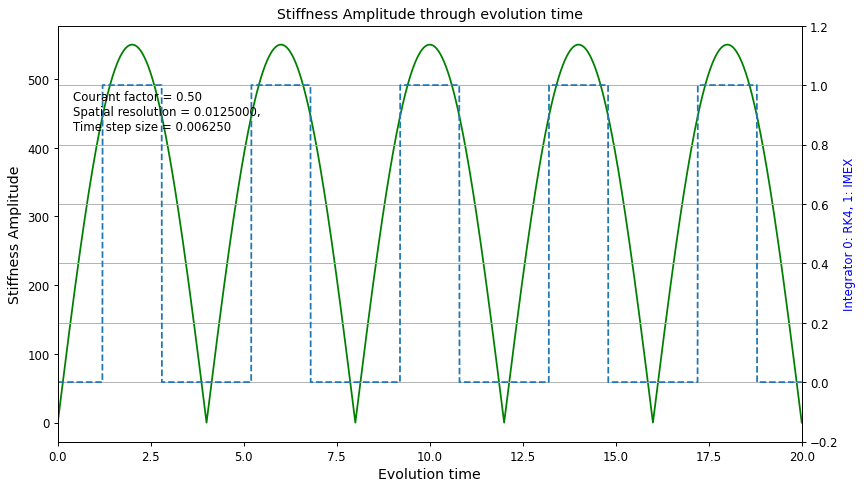

In [15]:
def plot(title,x_label,y_label,x_param,y_param1,dx,dt):
    fig_dpi = 85
    fig, ax1 = plt.subplots(figsize=(960/fig_dpi,540/fig_dpi),dpi = fig_dpi)
    plt.title(title,fontsize=12)
    plt.xlabel(x_label,fontsize=12)
    plt.ylabel(y_label,fontsize=12)
    ax2 = ax1.twinx()
    ax1.plot(x_param, y_param1, 'g-')
    ax2.plot(x_param, TIM_strings, '--')
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    ax2.set_ylabel('Integrator 0: RK4, 1: IMEX', color='b')
    ax2.axis([0,20,-0.2,1.2])
    plt.grid(axis="both")
    plt.text(0.02, 0.75,
             'Courant factor = %0.2f\nSpatial resolution = %.7f,\nTime step size = %.6f'
             %(Courant_factor,dx,dt),transform=ax1.transAxes)
    plt.show()
counter = 0
for i in range (len(TIM_strings)):
    if (TIM_strings[i] == 1):
        counter += 1
ratio = counter/len(TIM_strings)
print("IMEX:RK4 ratio = %.1f:%.1f"%(ratio*100,100-(ratio*100)))
plot('Stiffness Amplitude through evolution time',
                   'Evolution time','Stiffness Amplitude',
                   var_t_4h,dynamic_stiffness,dx,dt_4h)

0


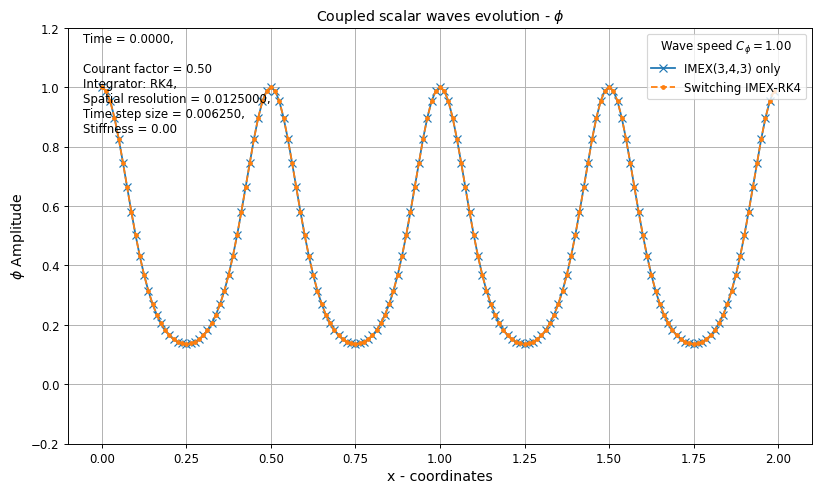

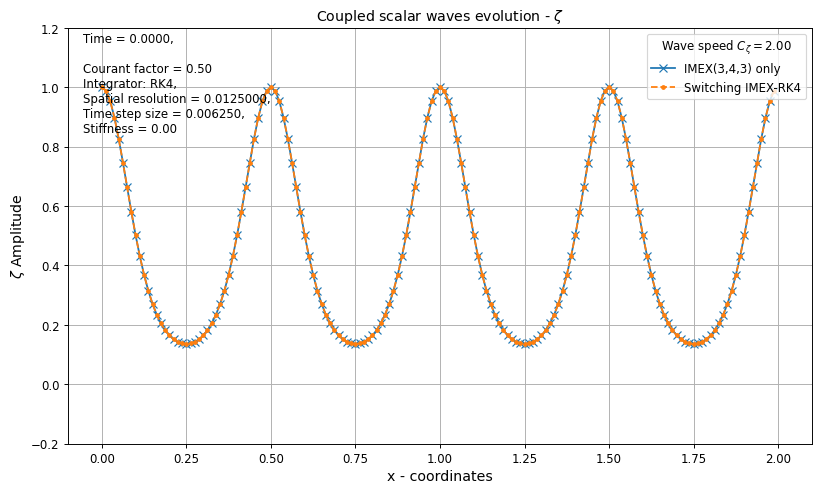

320


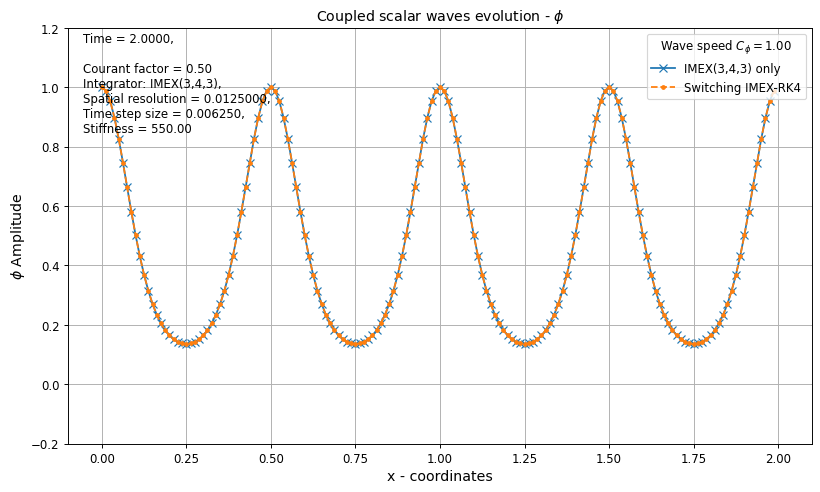

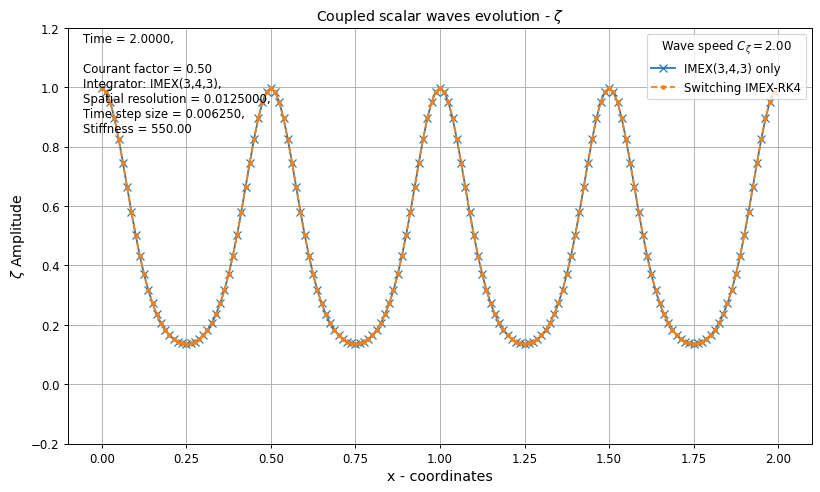

640


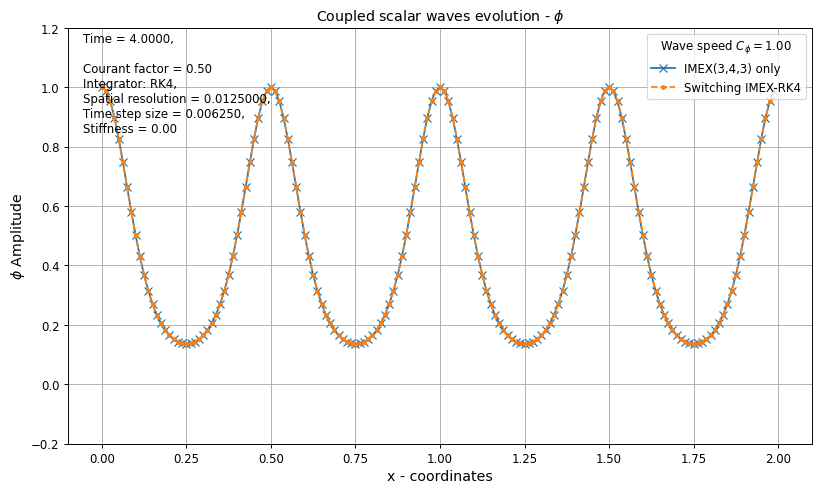

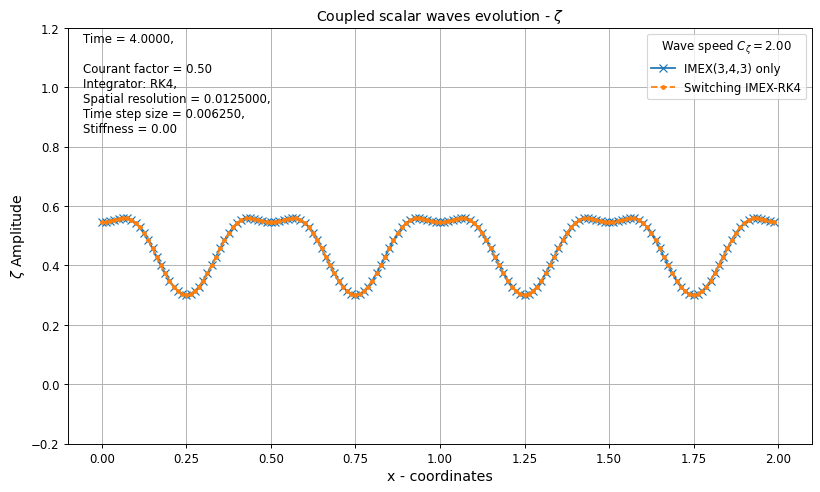

960


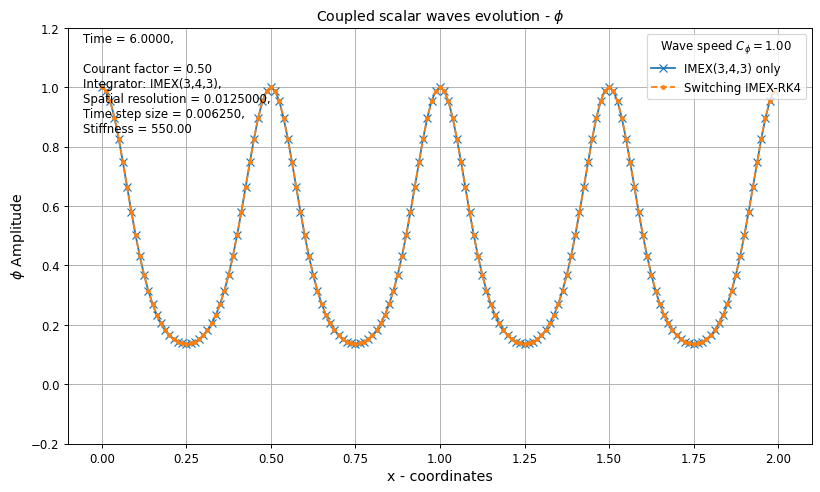

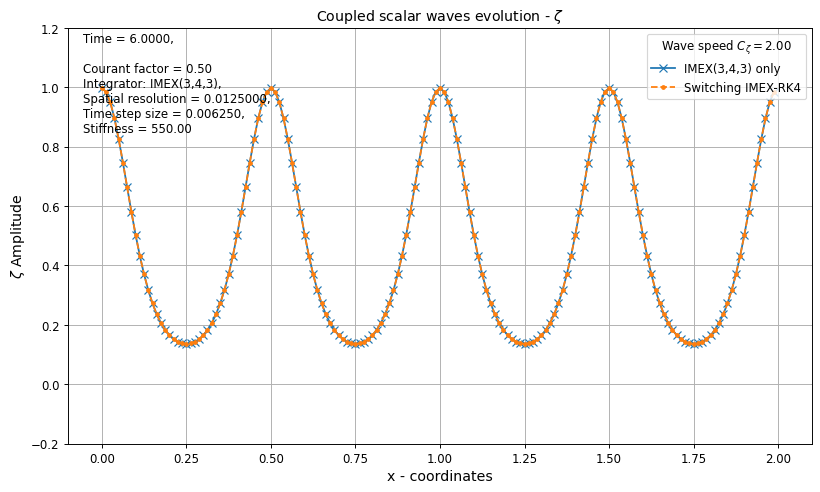

1280


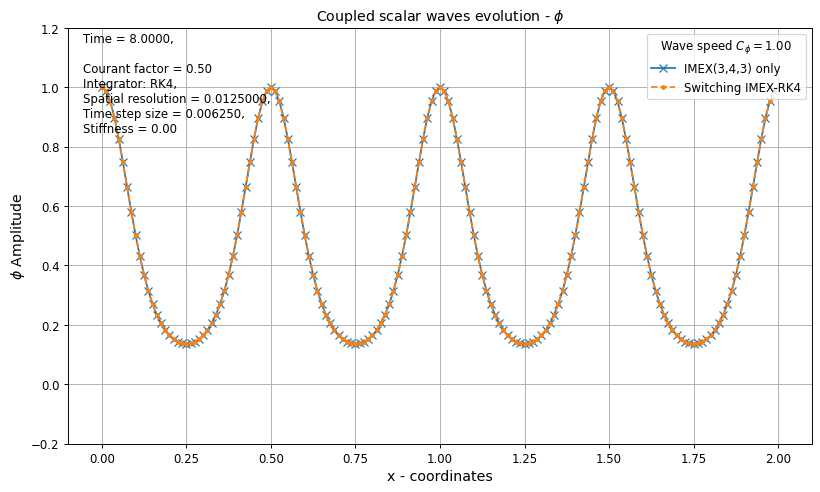

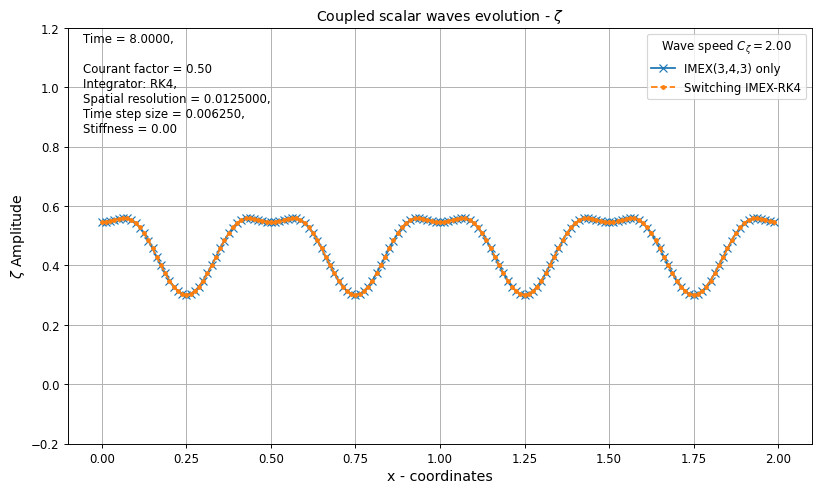

1600


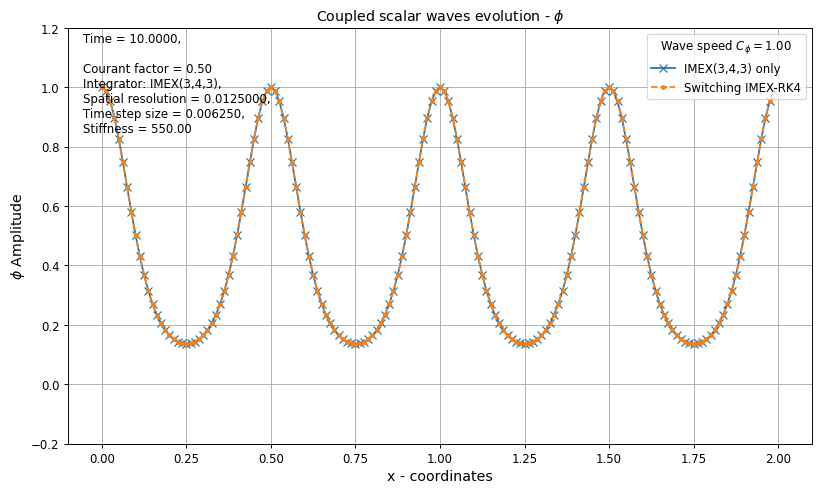

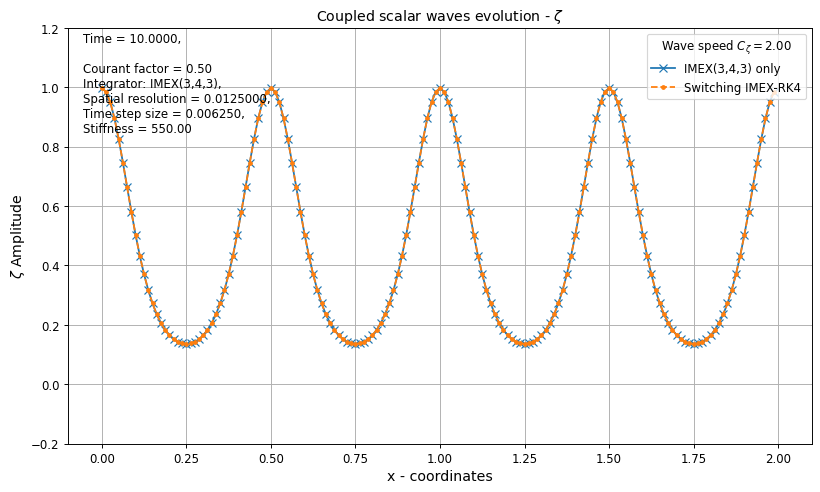

1920


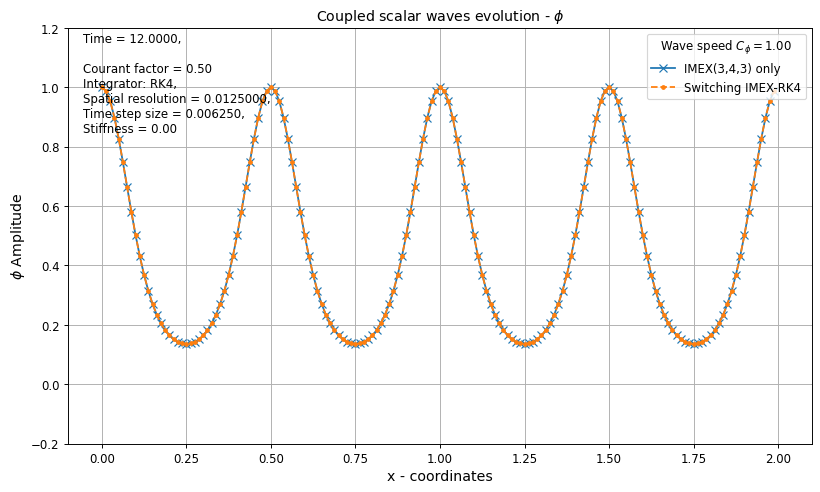

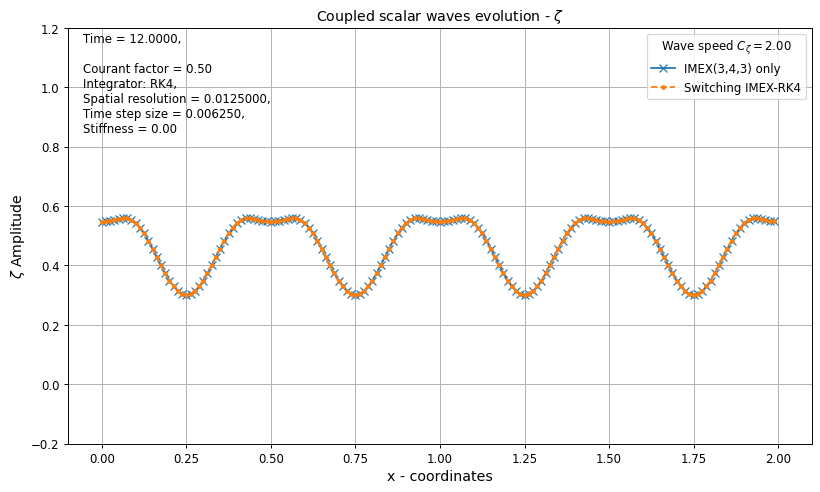

2240


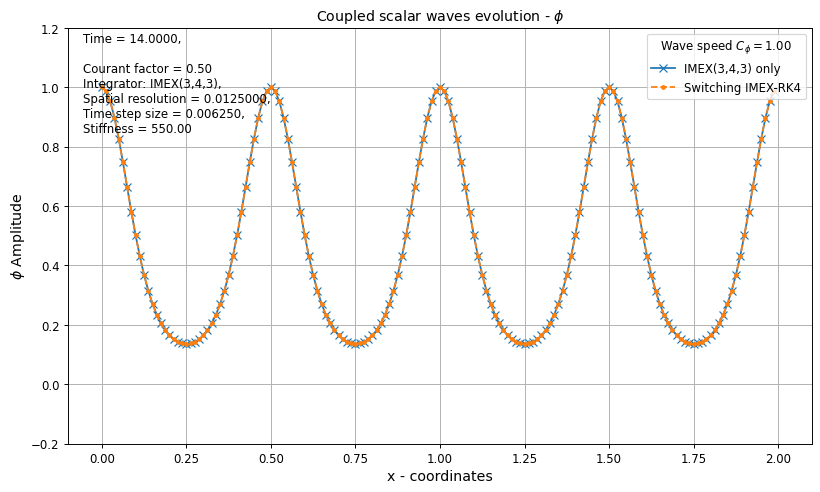

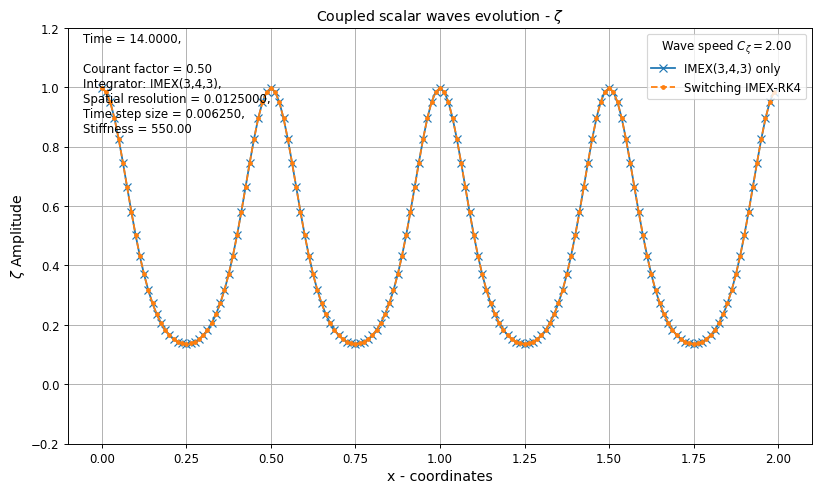

2560


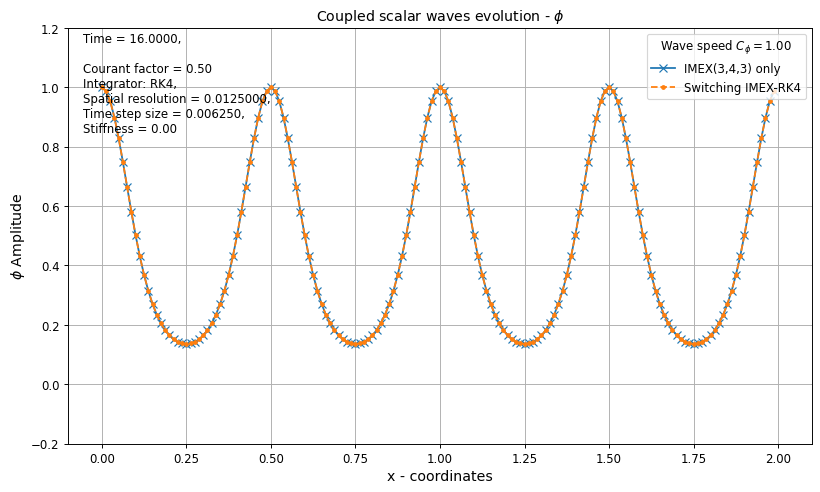

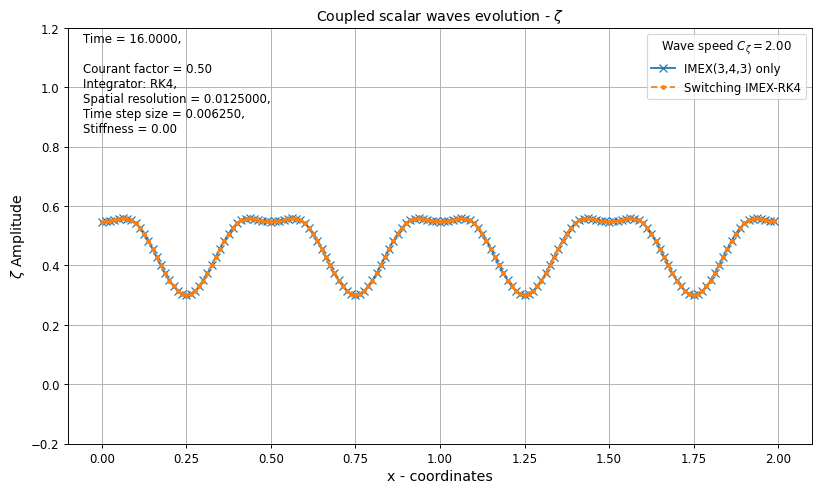

2880


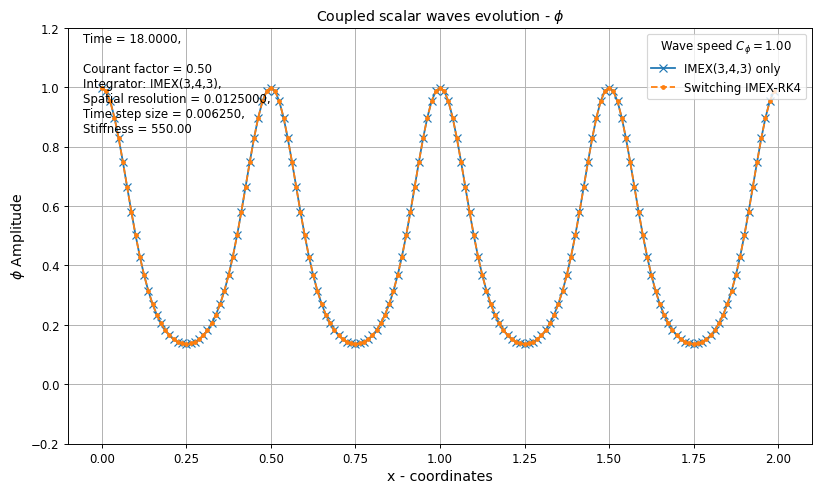

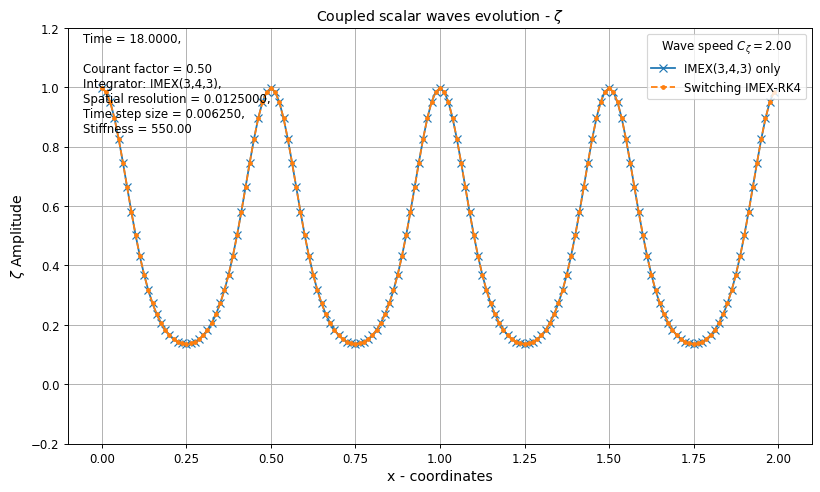

3200


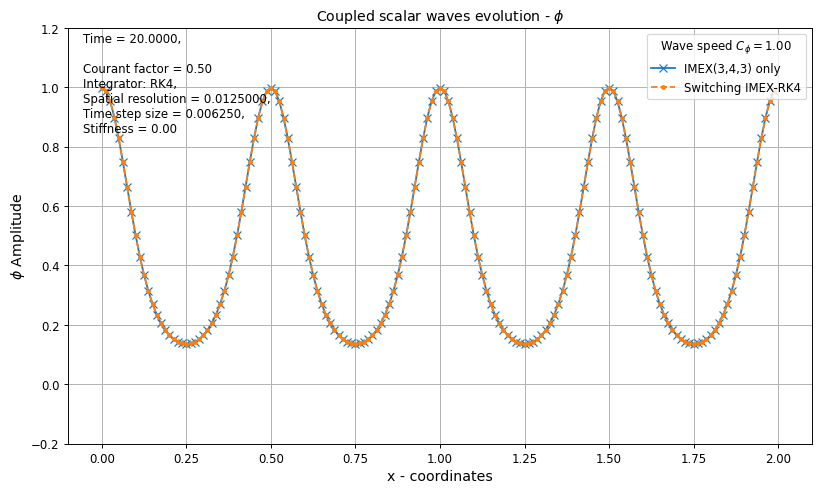

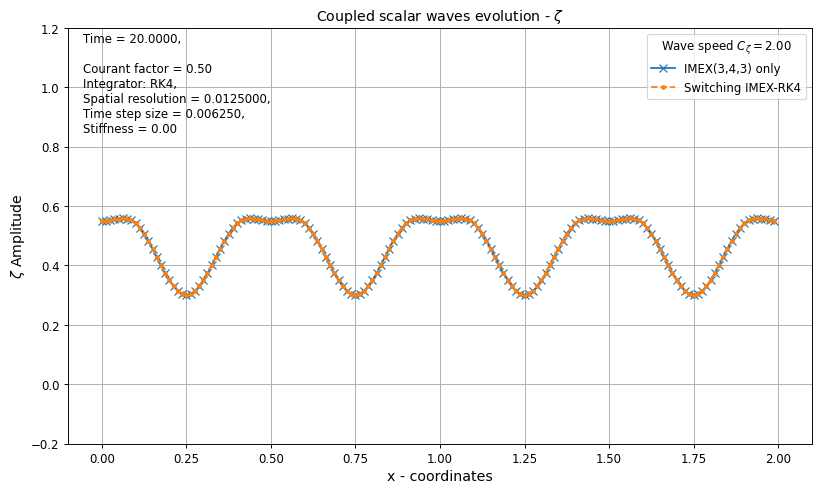

In [16]:
# Plot evolution of wave function
###-------------------------------------------------###
def plot_evolution(title,x_label,y_label,x_param,y_param1,y_param2,var_t,dx,dt,i,evol_variable):
    fig_dpi = 85
    fig, ax = plt.subplots(figsize=(960/fig_dpi,540/fig_dpi),dpi = fig_dpi)
    plt.title(title,fontsize=12)
    plt.xlabel(x_label,fontsize=12)
    plt.ylabel(y_label,fontsize=12)
    ax.axis([-0.1,2.1,-0.2,1.2])
    plt.plot(x_param,y_param1,'-x')
    plt.plot(x_param,y_param2,'--.')
    plt.grid(axis="both")
    plt.legend(["IMEX(3,4,3) only","Switching IMEX-RK4"],
               title=evol_variable,loc='upper right',fontsize=10)
    plt.text(0.02, 0.75,
             'Time = %.4f,\n\nCourant factor = %0.2f\nIntegrator: %s,\nSpatial resolution = %.7f,\nTime step size = %.6f,\nStiffness = %.2f'
             %(var_t[i],Courant_factor,("RK4" if TIM_strings[i] == 0  else "IMEX(3,4,3)"),dx,dt,dynamic_stiffness[i]),transform=ax.transAxes)
    plt.show()

plots_to_generate = 10
for i in range (0,Nt_4h,int(Nt_4h/plots_to_generate)):
    print(i)
    plot_evolution(r'Coupled scalar waves evolution - $\phi$',
                   "x - coordinates",r'$\phi$ Amplitude',
                   var_x_4h,phi_4h[i,:],phi_4h_hIMEX[i,:],var_t_4h,dx,dt_4h,i,r'Wave speed $C_{\phi}=%0.2f$'%wave_speed_phi)
    plot_evolution(r'Coupled scalar waves evolution - $\zeta$',
                   "x - coordinates",r'$\zeta$ Amplitude',
                   var_x_4h,zeta_4h[i,:],zeta_4h_hIMEX[i,:],var_t_4h,dx,dt_4h,i,r'Wave speed $C_{\zeta}=%0.2f$'%wave_speed_zeta)

0


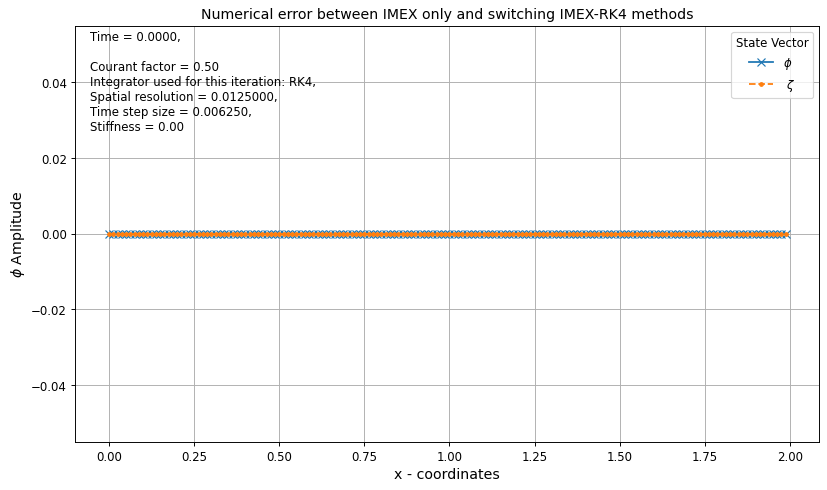

320


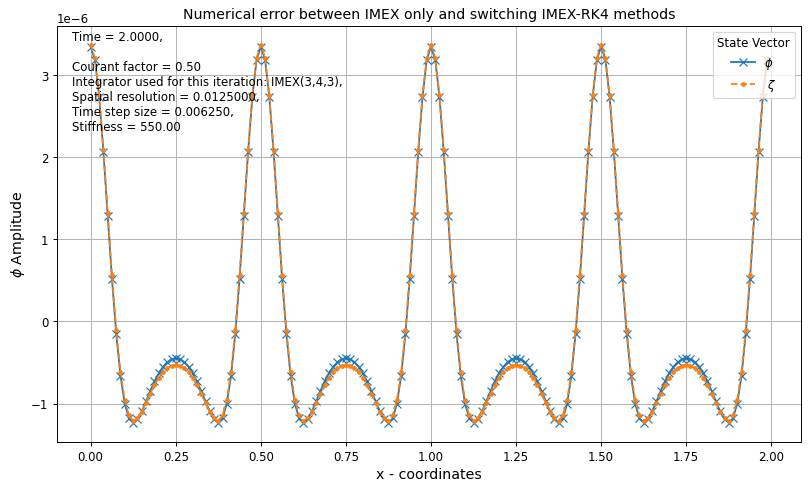

640


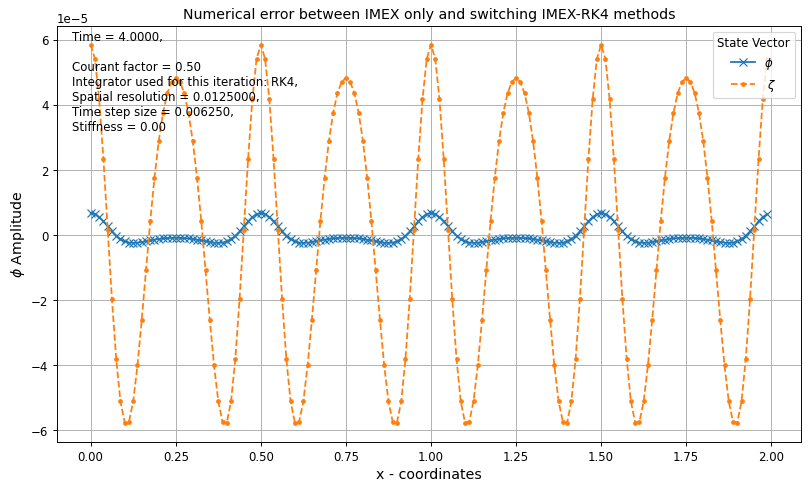

960


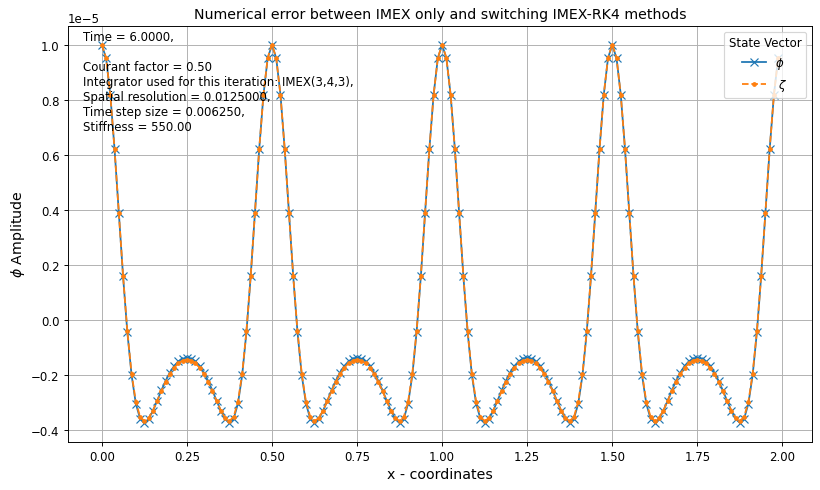

1280


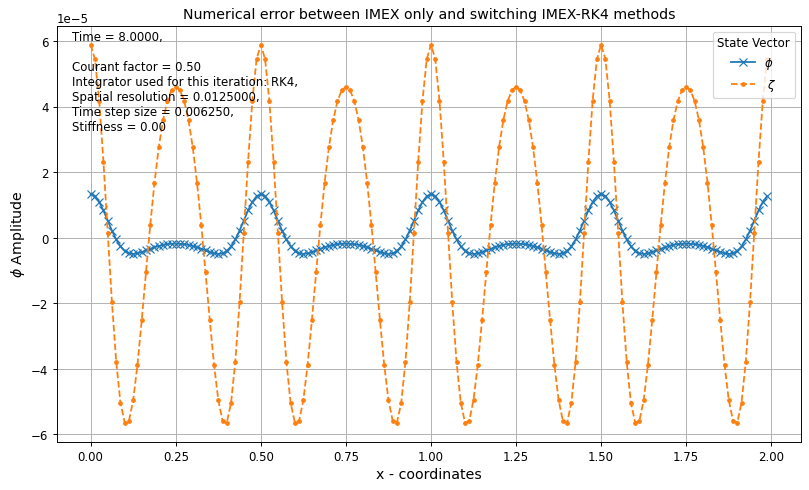

1600


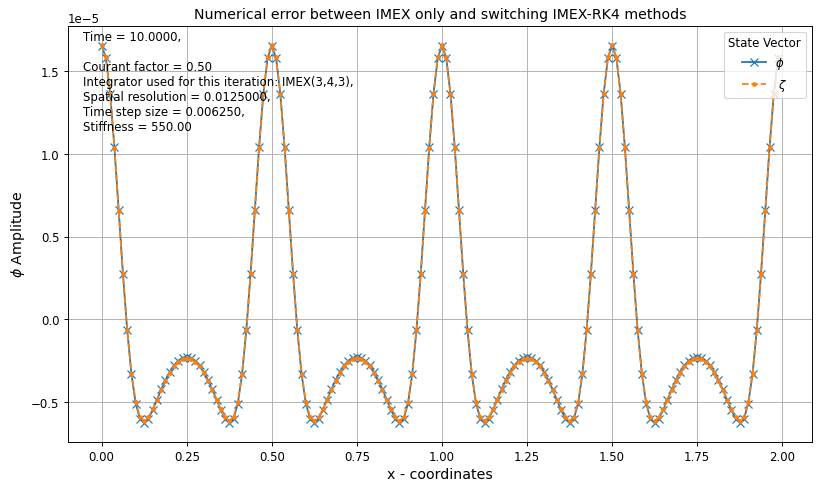

1920


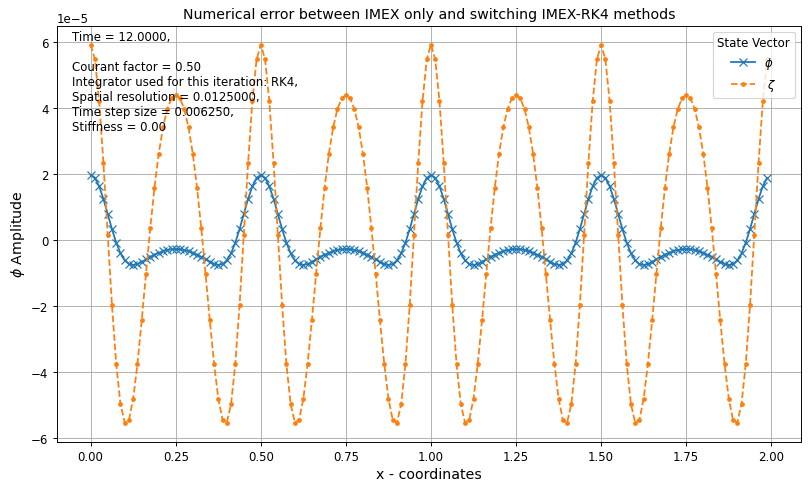

2240


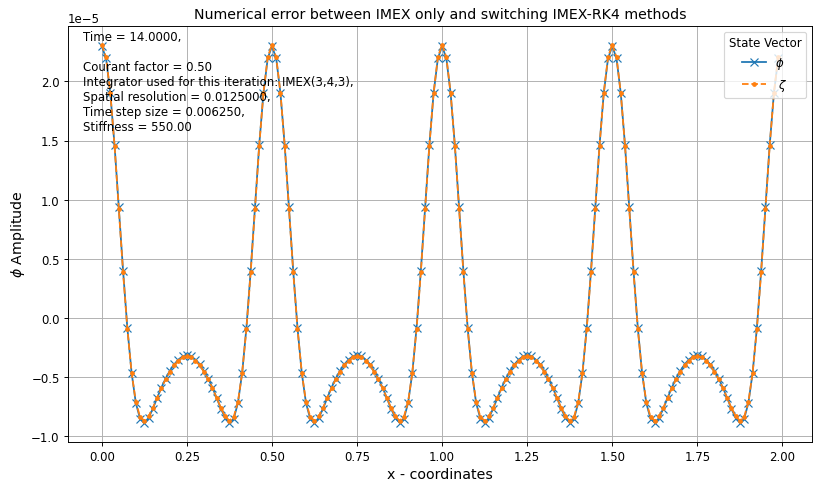

2560


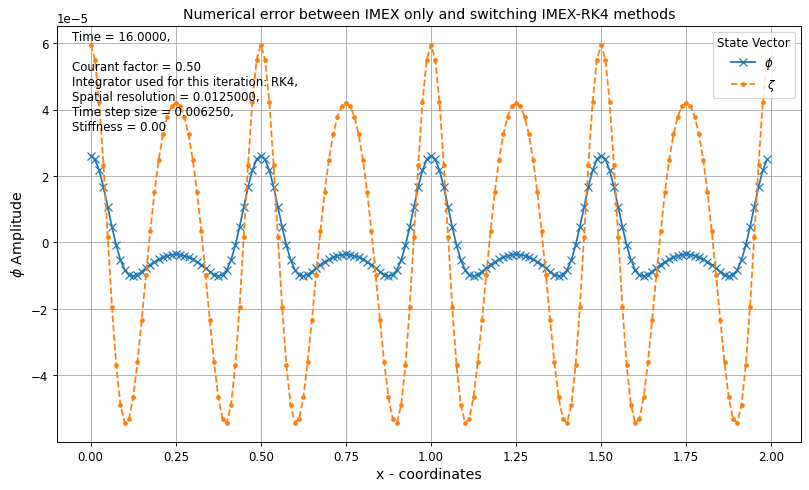

2880


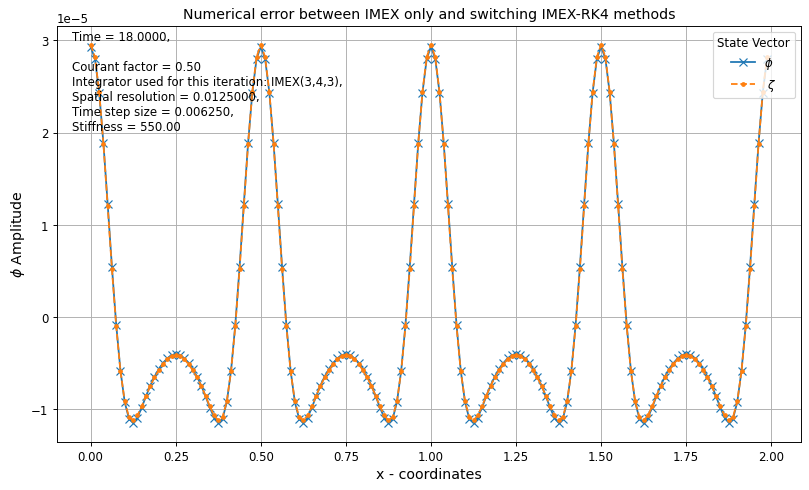

3200


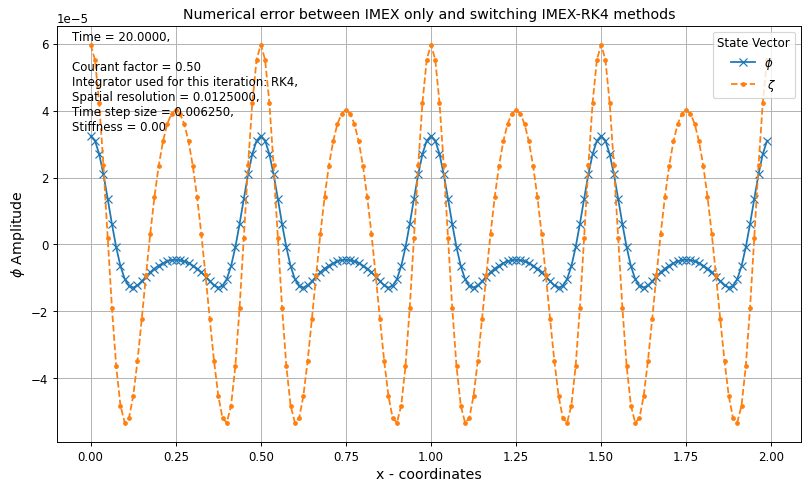

In [17]:
# Plot evolution of wave function
###-------------------------------------------------###
def plot_error(title,x_label,y_label,x_param,y_param1,y_param2,var_t,dx,dt,i):
    fig_dpi = 85
    fig, ax = plt.subplots(figsize=(960/fig_dpi,540/fig_dpi),dpi = fig_dpi)
    plt.title(title,fontsize=12)
    plt.xlabel(x_label,fontsize=12)
    plt.ylabel(y_label,fontsize=12)
    #ax.axis([-0.1,2.1,-0.2,1.2])
    plt.plot(x_param,y_param1,'-x')
    plt.plot(x_param,y_param2,'--.')
    plt.grid(axis="both")
    plt.legend([r"$\phi$",r" $\zeta$"],
               title="State Vector",loc='upper right',fontsize=10)
    plt.text(0.02, 0.75,
             'Time = %.4f,\n\nCourant factor = %0.2f\nIntegrator used for this iteration: %s,\nSpatial resolution = %.7f,\nTime step size = %.6f,\nStiffness = %.2f'
             %(var_t[i],Courant_factor,("RK4" if TIM_strings[i] == 0  else "IMEX(3,4,3)"),dx,dt,dynamic_stiffness[i]),transform=ax.transAxes)
    plt.show()

plots_to_generate = 10
for i in range (0,Nt_4h,int(Nt_4h/plots_to_generate)):
    print(i)
    plot_error(r'Numerical error between IMEX only and switching IMEX-RK4 methods',
                   "x - coordinates",r'$\phi$ Amplitude',
                   var_x_4h,phi_4h[i,:]-phi_4h_hIMEX[i,:],zeta_4h[i,:]-zeta_4h_hIMEX[i,:],var_t_4h,dx,dt_4h,i)